### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]

### Constants and conversion factors

In [2]:
# Constants
h = 0.6727
H0 = 67.27
Omega_m = 0.26495
Omega_b = 0.05
Omega_rad = 10e-5
p_crit = 4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T0 = 2.7255
kb = 8.617333262145e-5
T_0 = kb*T0*1e-9
m_p = 0.93827231
Y_p = 0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
Rx_conerverionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

### Definitions

In [3]:
def N_0(n):
    return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

In [4]:
def mhm2khm(Mhm):
    return np.pi/h*(((4.*np.pi*rho_crit)/(3*Mhm))**(1./3.))

In [5]:
def Rx_noZ(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow((T_0/m_x)+(T_0/m_p),((1.+n)/2.)))

In [6]:
def z_th(sigma_0,m_x,n):
    return ((H0*np.sqrt(Omega_rad)*(m_x+m_p))/(Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

In [7]:
def z_kin(sigma_0,m_x,n):
    return fsolve(lambda z: z * ((T_0*z**2)/(z_th(sigma_0,m_x,n)*m_x) + (T_0*z_th(sigma_0,m_x,n))/m_p)**((n+1.)/2.) - (H0*np.sqrt(Omega_rad)/(N_0(n)*Y_p*p_b*Rx_conerverionFactor))*(m_x+m_p)/sigma_0,z_th(sigma_0,m_x,n)/2.)    

In [8]:
# Equation 4
def sigma2k(sigma_0,m_x,n):
    return (H0*np.sqrt(Omega_rad)*z_kin(sigma_0,m_x,n))*3.33e-6

# Equation 4
def sigma2k2(sigma_0,m_x,n):
    return (H0*np.sqrt(Omega_rad)*z_th(sigma_0,m_x,n))*3.33e-6

In [9]:
def Rx_kin(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow((T_0*pow(z_kin(sigma_0,m_x,n),2))/(m_x*z_th(sigma_0,m_x,n))+((T_0*z_th(sigma_0,m_x,n))/m_p),((1.+n)/2.)))

In [10]:
def Rx_th(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow(((T_0*(1+z_th(sigma_0,m_x,n)))/(m_x))+((T_0*(1+z_th(sigma_0,m_x,n)))/m_p),((1.+n)/2.)))

In [11]:
def sig(klimit,n):
    sigma = []
    for i in range(len(masses)):
        sigma.append(sigma_array[np.argmin(np.abs(sigma2k(sigma_array,masses[i],n)-h*klimit))])
    return np.array(sigma)

def sigma_vs_mx(klimit):
    return hv.Curve((masses, sig(klimit)))

In [12]:
def Rx_before_zth(z, sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow((T_0*z)/(m_x)+((T_0*z)/m_p),((1.+n)/2.)))

In [13]:
def Rx_after_zth(z, sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*Rx_conerverionFactor*(sigma_0/(m_x+m_p))*(pow((T_0*pow(z,2))/(m_x*z_th(sigma_0,m_x,n))+((T_0*z)/m_p),((1.+n)/2.)))

### Plots

findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


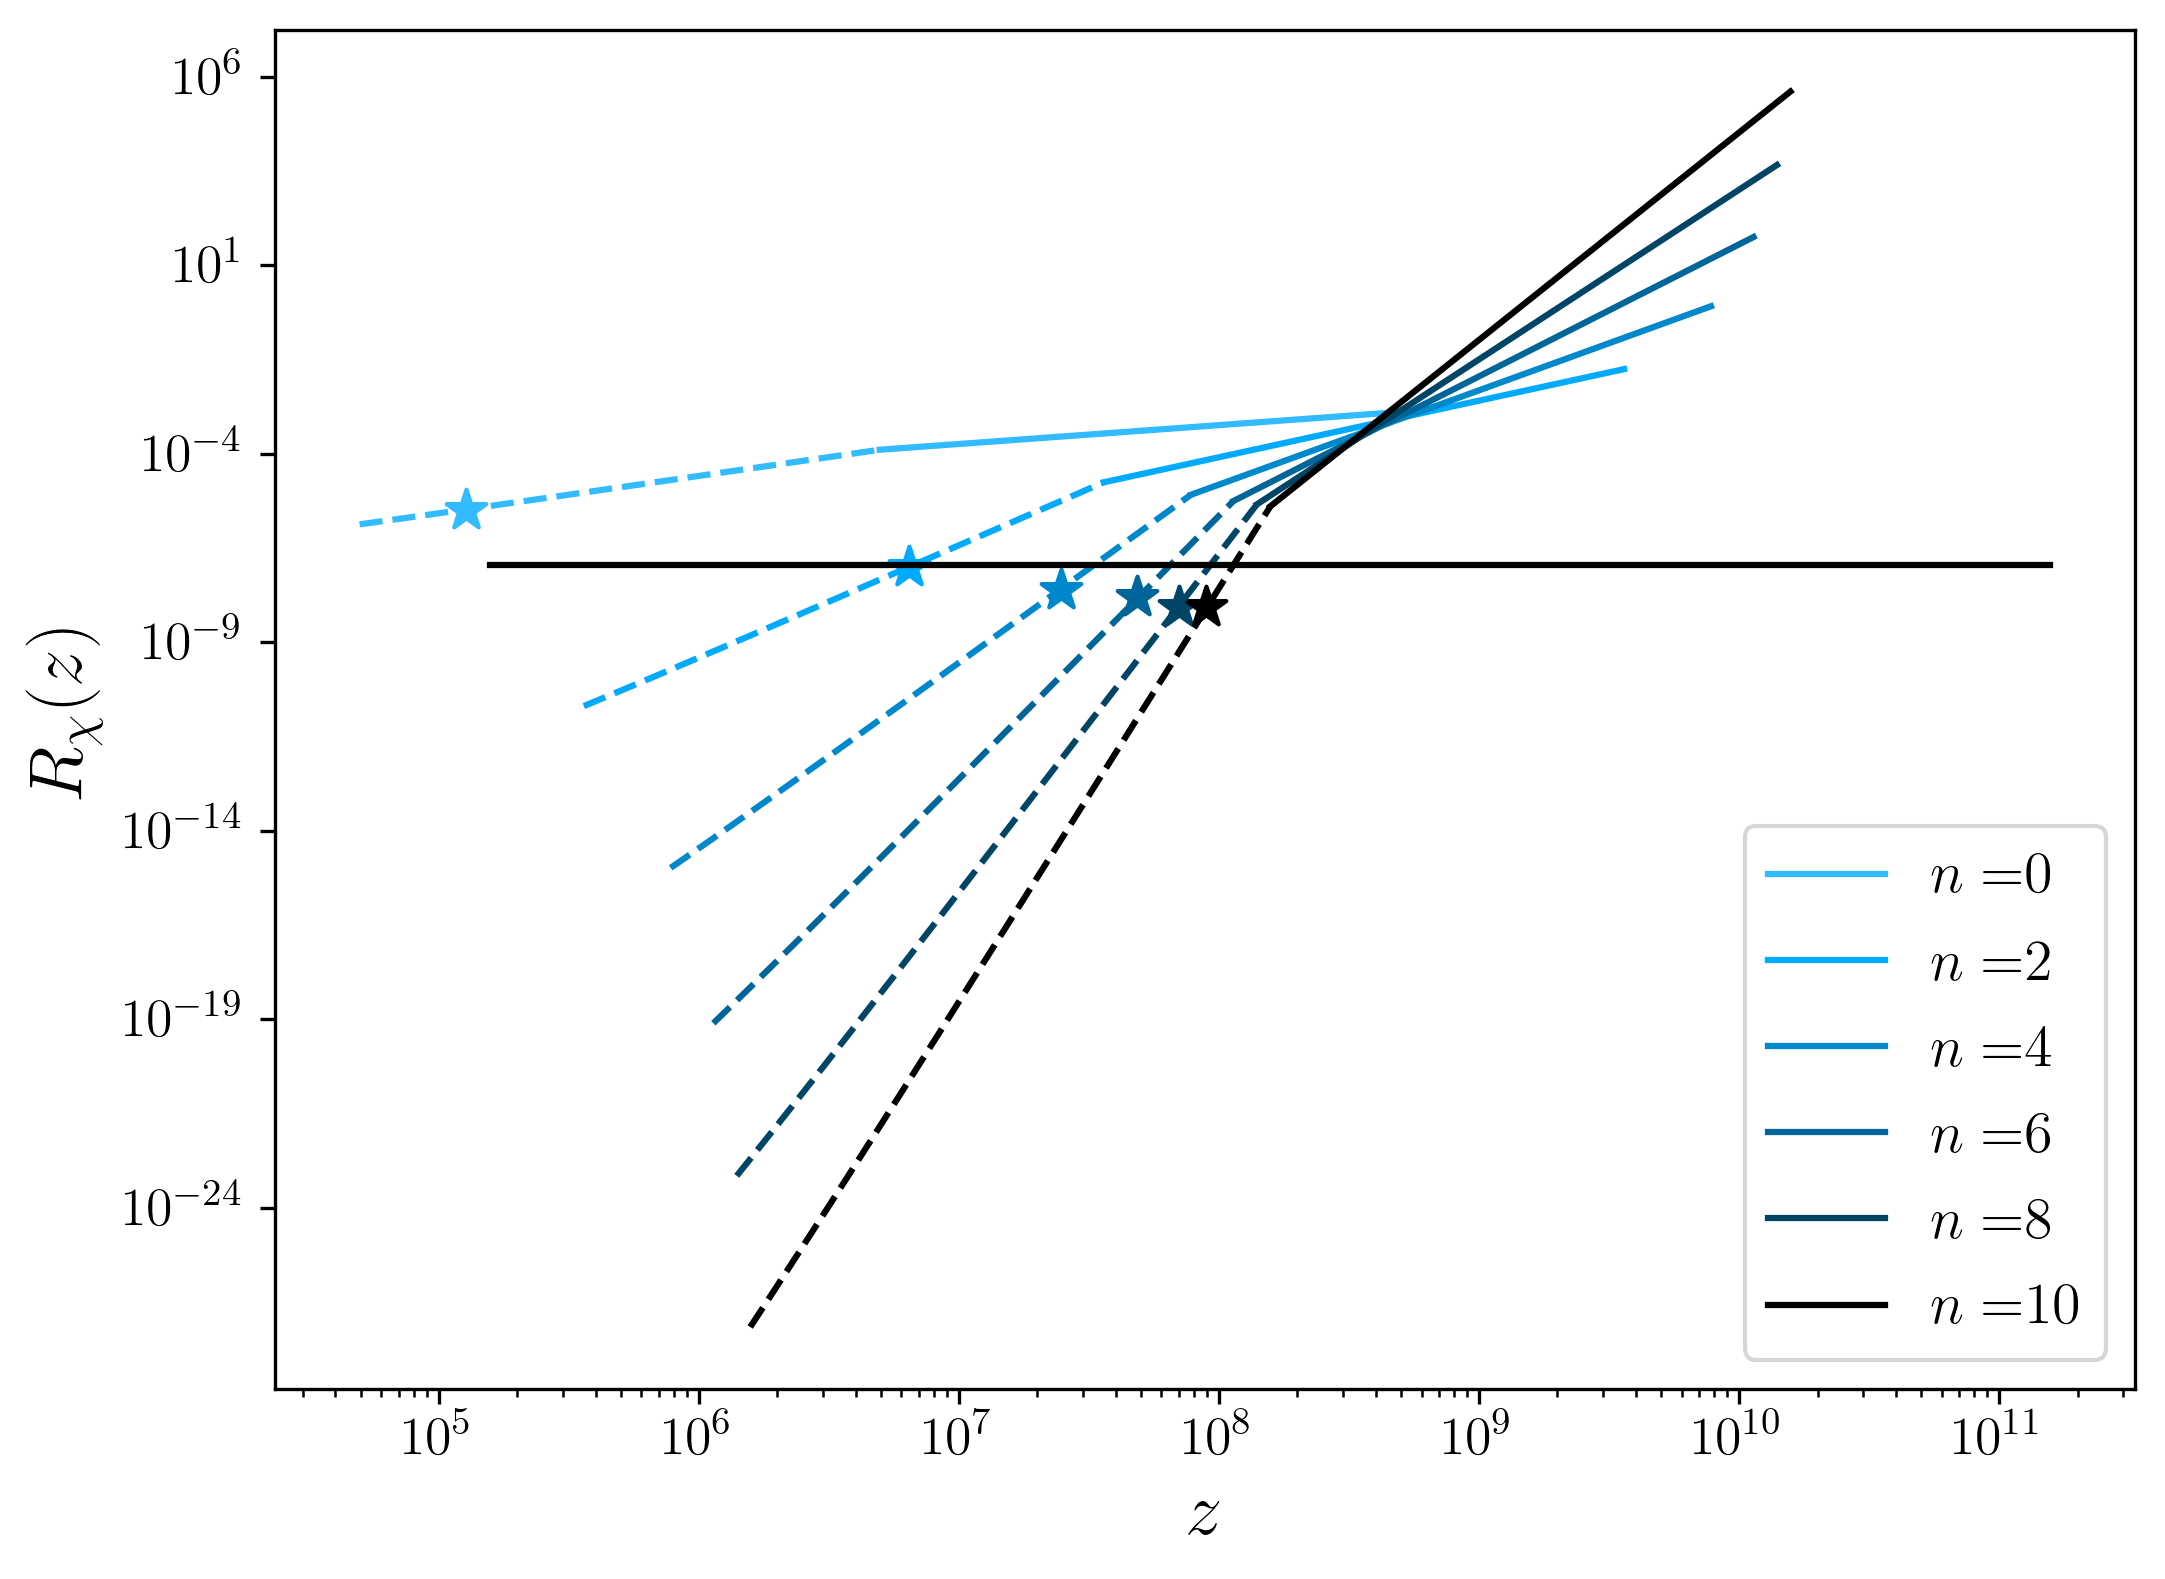

In [14]:
plt.figure(figsize=(8,6))

i=2

for n in np.array([0,2,4,6,8,10]):
    zth = z_th(1e-26,1e-3,n)
    zkin = z_kin(1e-26,1e-3,n)

    zs1 = np.logspace(np.log10(zth),np.log10(100.*zth),100)
    zs2 = np.logspace(np.log10(zth/100.),np.log10(zth),100)
    
    plt.scatter(zkin,Rx_after_zth(zs2,1e-26,1e-3,n)[np.argmin(np.abs(zs2-zkin))],
               marker='*',s=100,c=custom_blues[i])

    plt.loglog(zs1,Rx_before_zth(zs1,1e-26,1e-3,n),c=custom_blues[i],label=r'$n=${}'.format(n))
    plt.loglog(zs2,Rx_after_zth(zs2,1e-26,1e-3,n),ls='--',c=custom_blues[i])
    i+=1

plt.loglog(np.linspace(np.min(zs2)/10.,np.max(zs1)*10.,100),3.33*10**-6/30*np.ones(100),'k-')

plt.xlabel(r'$z$',fontsize=18)
plt.ylabel(r'$R_{\chi}(z)$',fontsize=18)

plt.legend(loc=4,fontsize=14)
plt.show()

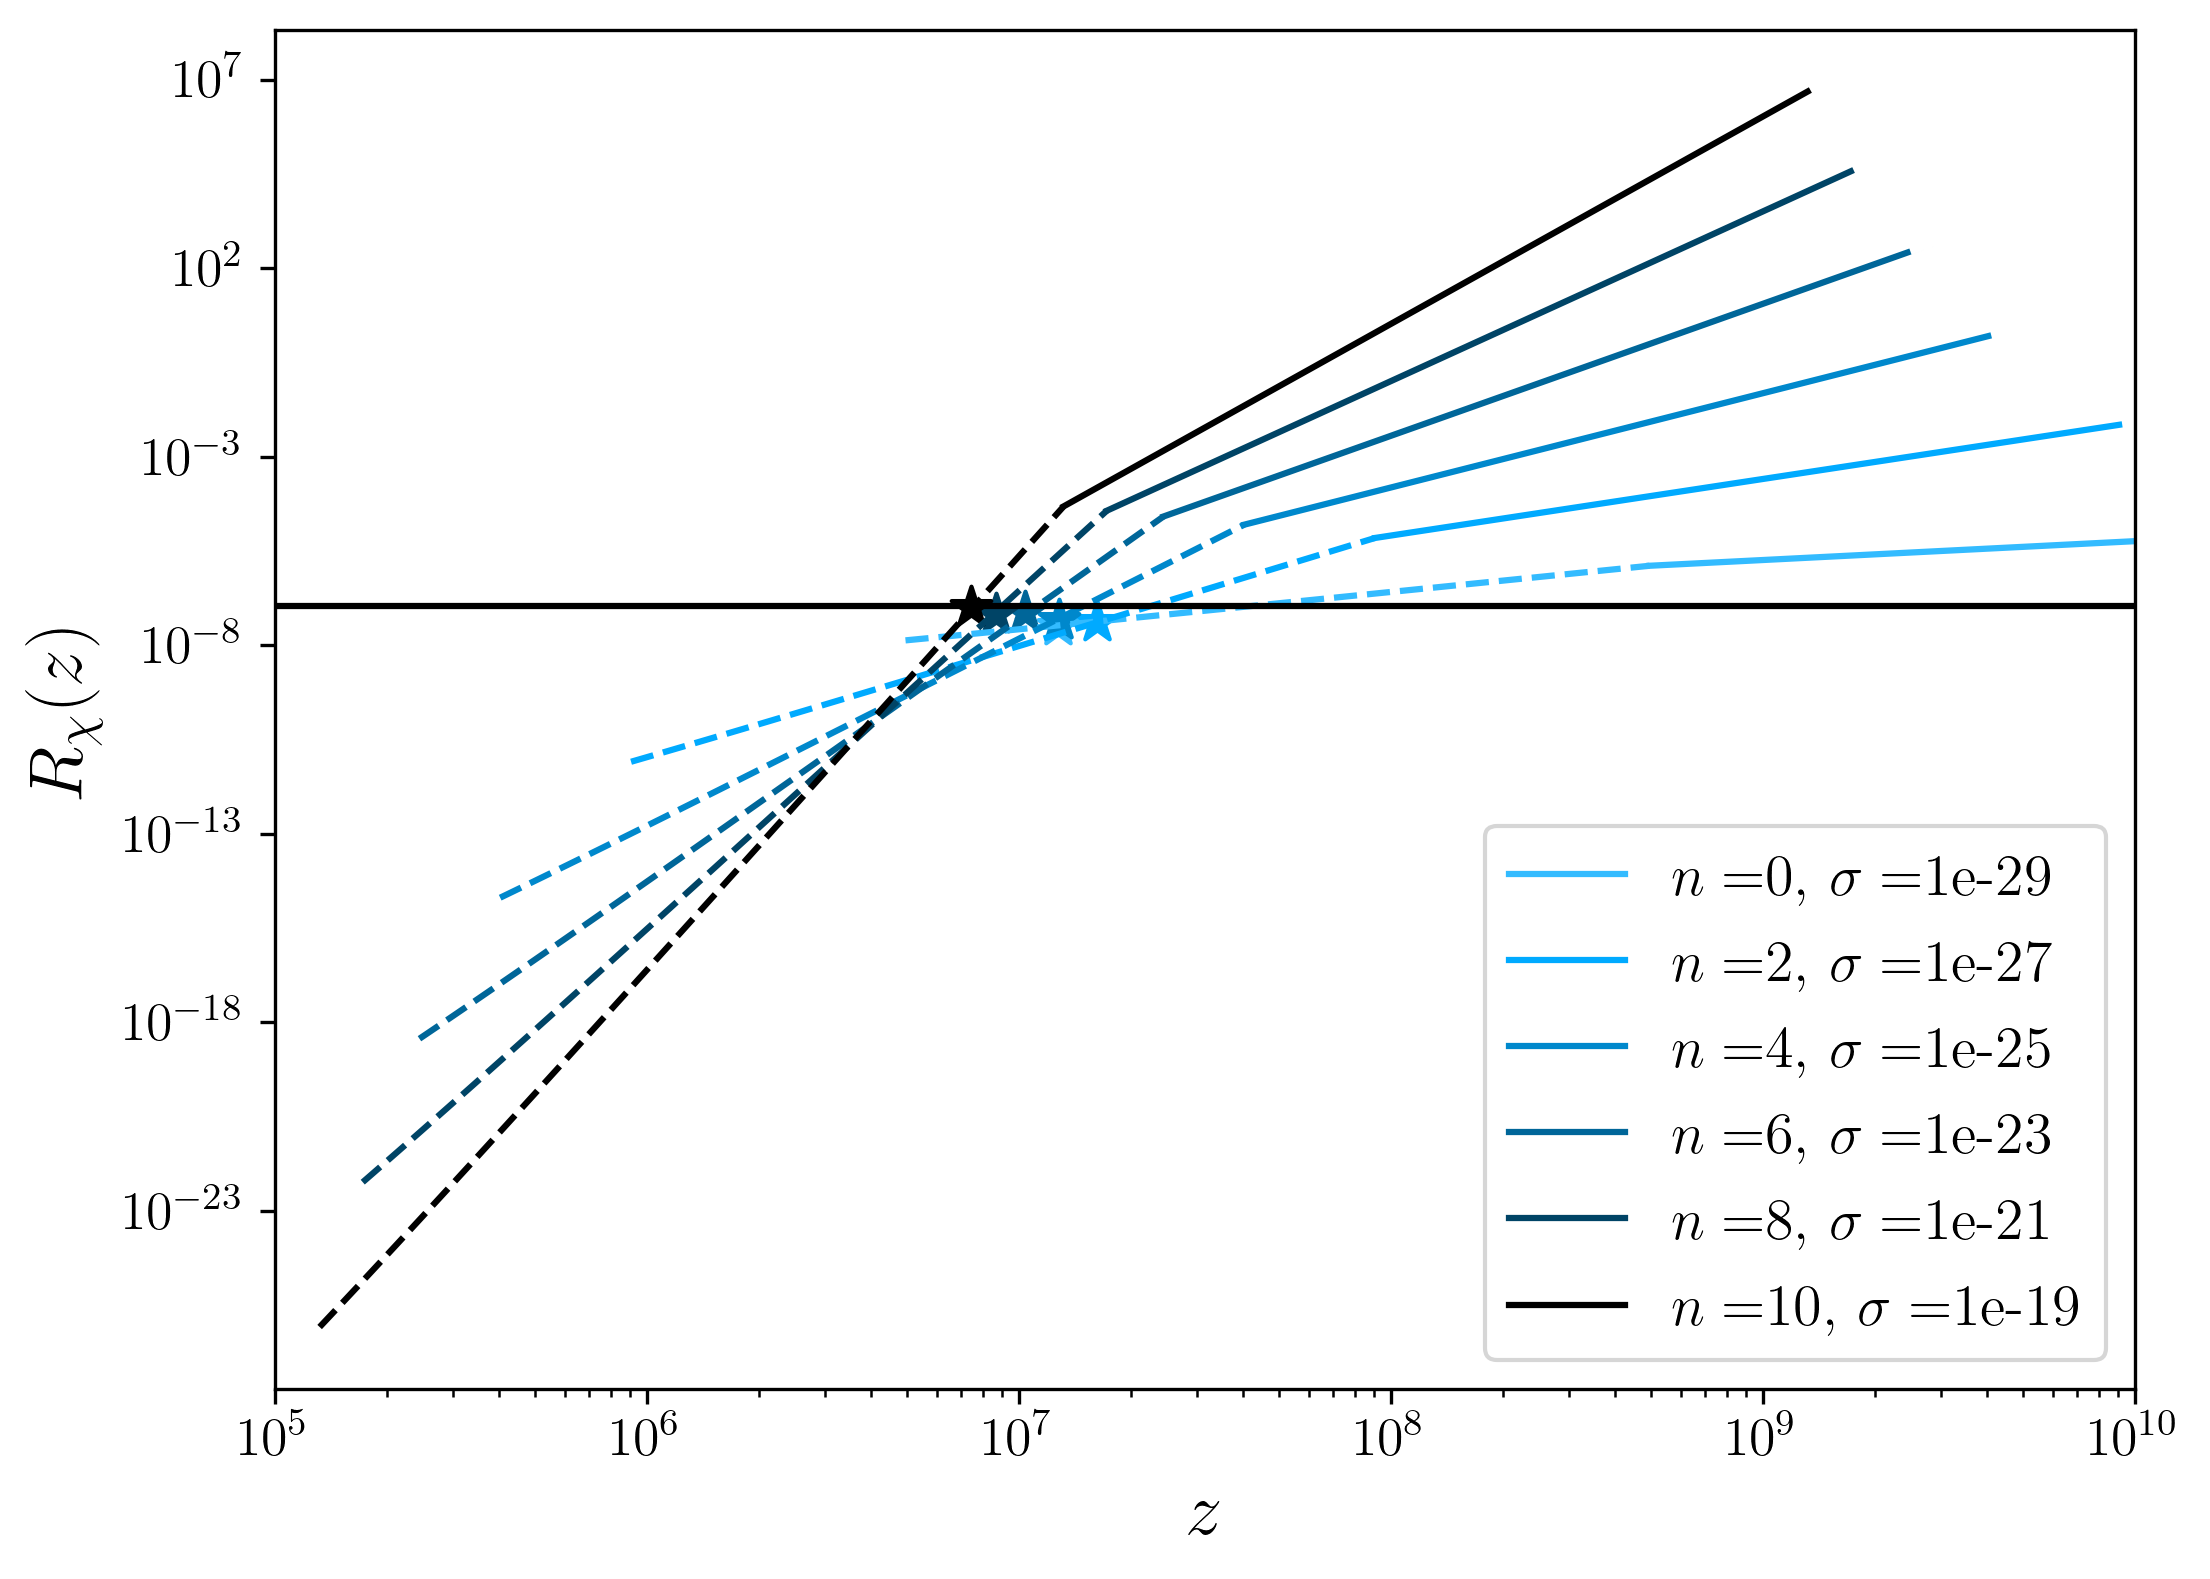

In [18]:
plt.figure(figsize=(8,6))


ns = np.array([0,2,4,6,8,10])
sigmas = np.array([1e-29,1e-27,1e-25,1e-23,1e-21,1e-19])

for k in range(len(ns)):
    zth = z_th(sigmas[k],1e-3,ns[k])
    zkin = z_kin(sigmas[k],1e-3,ns[k])

    zs1 = np.logspace(np.log10(zth),np.log10(100.*zth),100)
    zs2 = np.logspace(np.log10(zth/100.),np.log10(zth),100)
    
    plt.scatter(zkin,Rx_after_zth(zs2,sigmas[k],1e-3,ns[k])[np.argmin(np.abs(zs2-zkin))],
               marker='*',s=100,c=custom_blues[k+2])
    

    plt.loglog(zs1,Rx_before_zth(zs1,sigmas[k],1e-3,ns[k]),c=custom_blues[k+2],label=r'$n=${}, $\sigma=${}'.format(ns[k],sigmas[k]))
    plt.loglog(zs2,Rx_after_zth(zs2,sigmas[k],1e-3,ns[k]),ls='--',c=custom_blues[k+2])
    
plt.loglog(np.linspace(np.min(zs2)/10.,np.max(zs1)*10.,100),3.33*10**-6/30*np.ones(100),'k-')

plt.xlim(10**5,10**10)
plt.xlabel(r'$z$',fontsize=18)
plt.ylabel(r'$R_{\chi}(z)$',fontsize=18)

plt.legend(loc=4,fontsize=14)
plt.show()

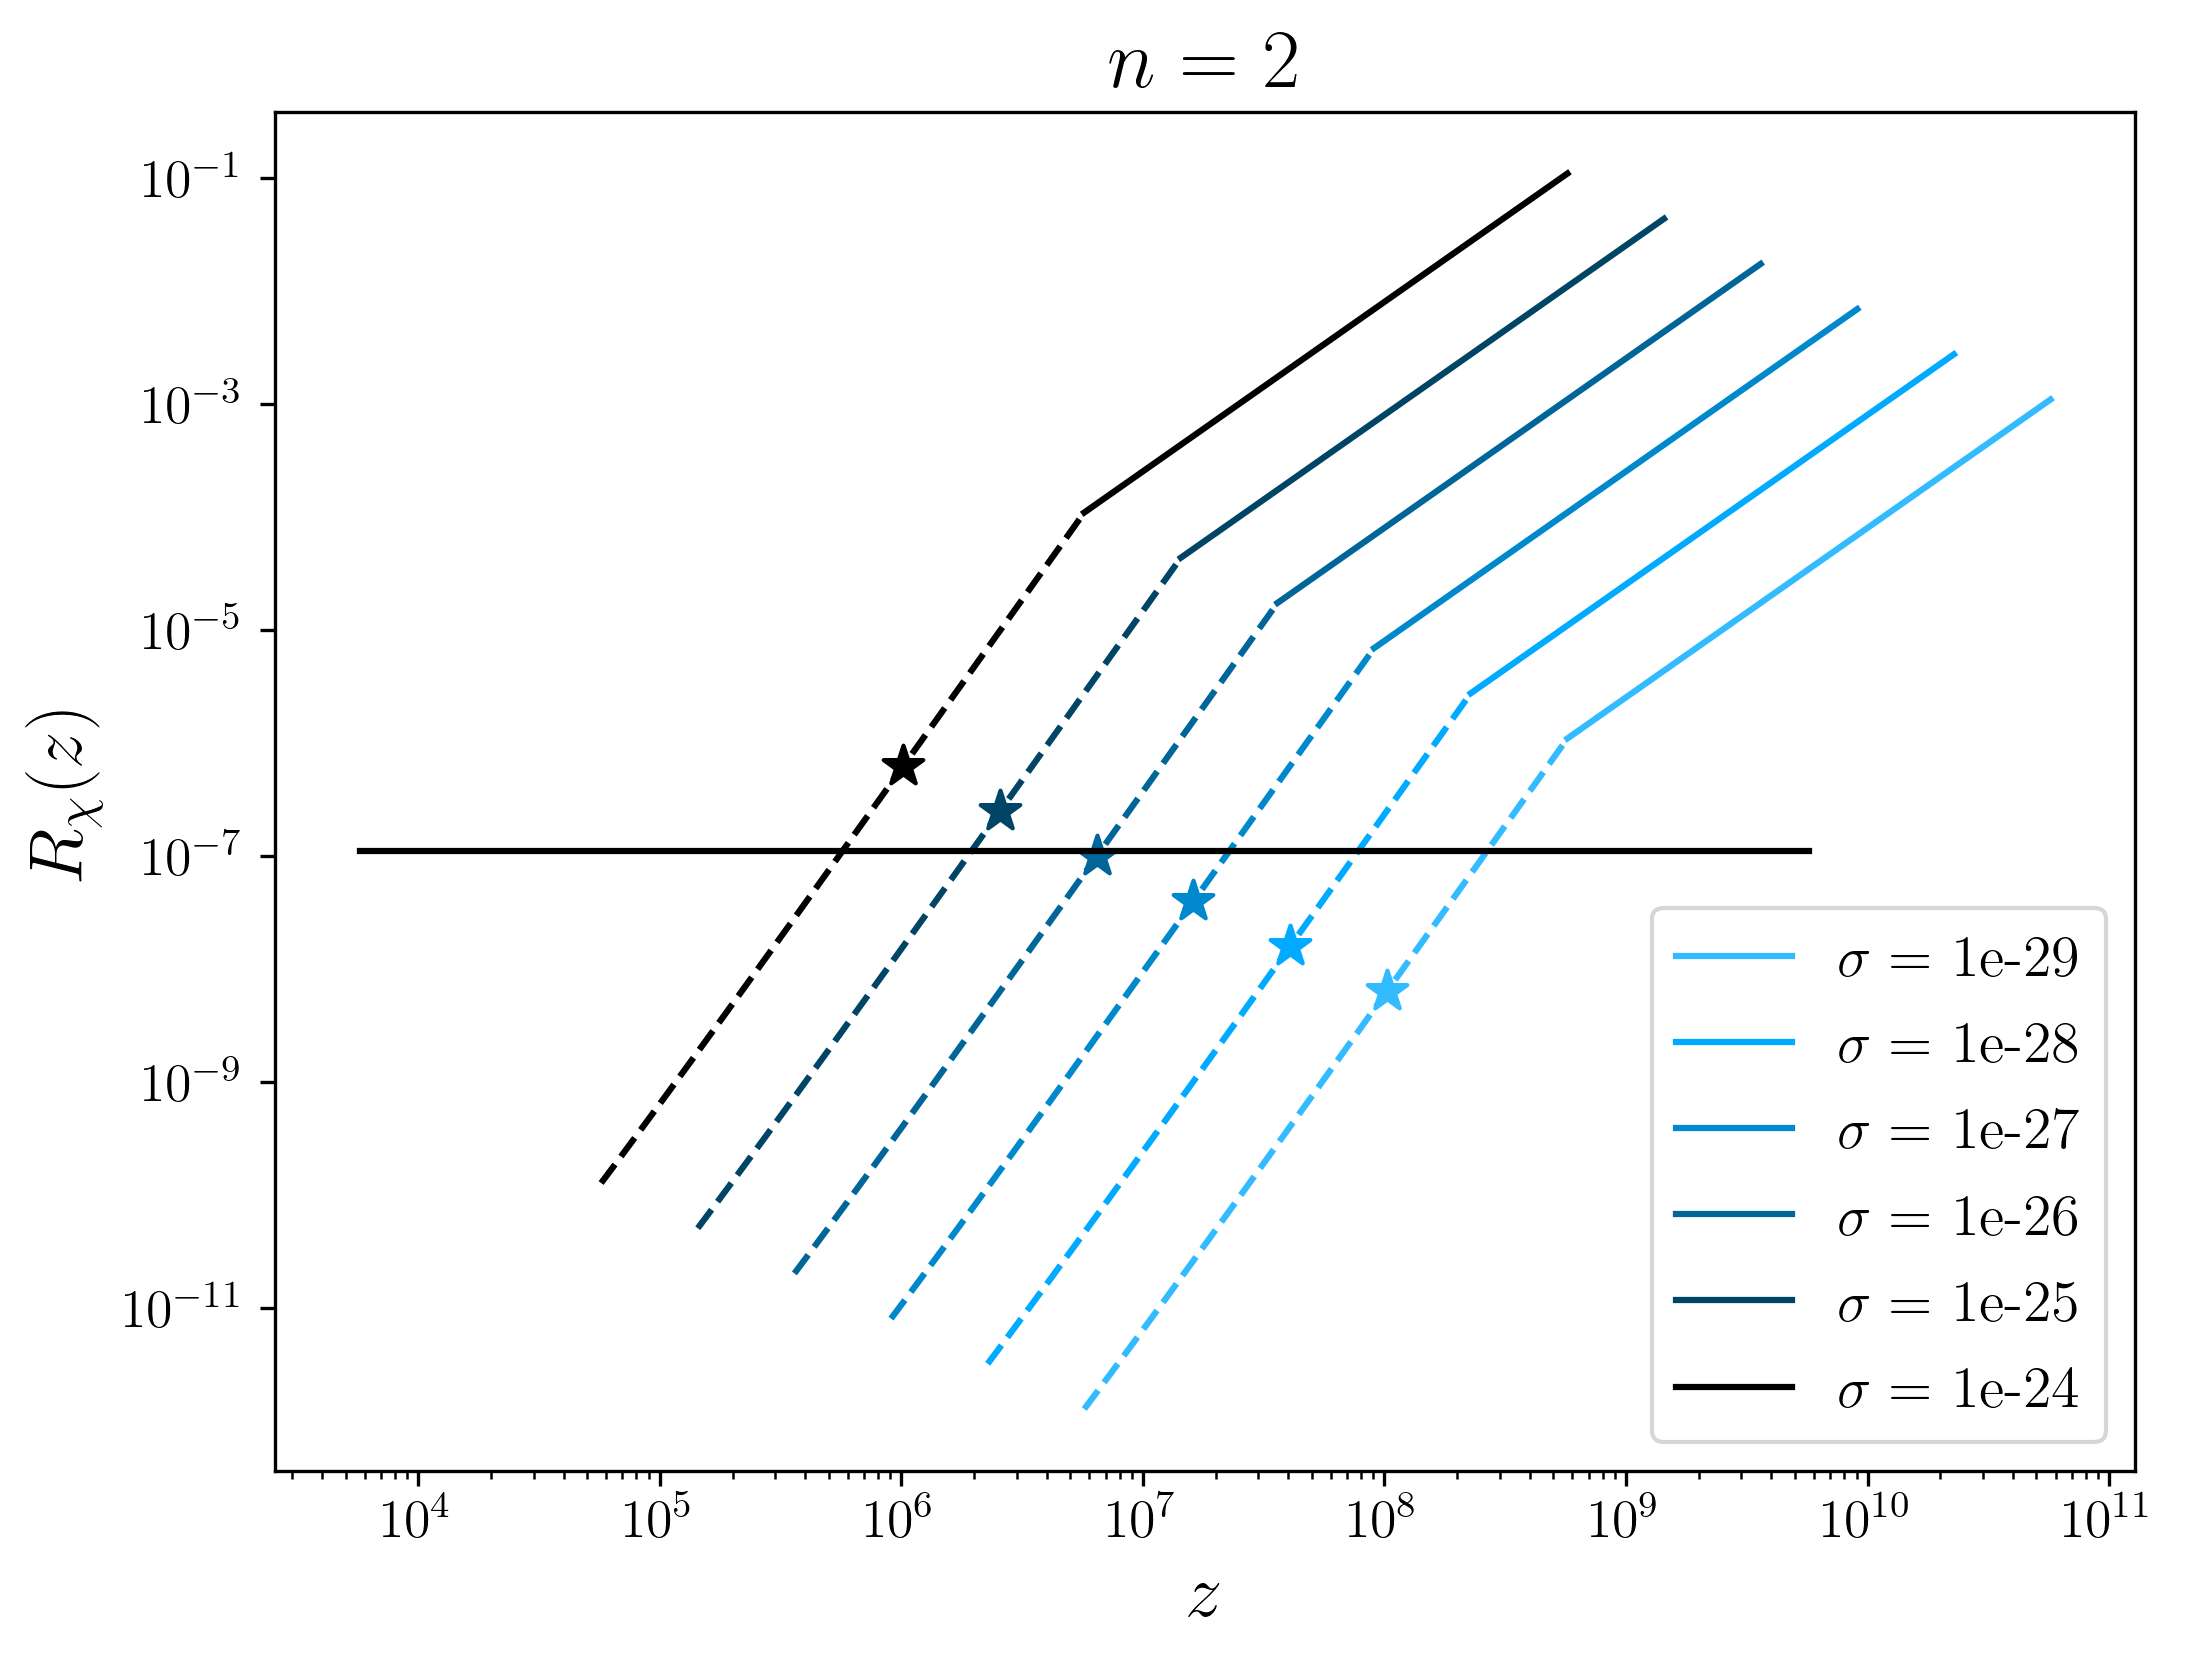

In [19]:
plt.figure(figsize=(8,6))

i=2
n=2

for sigma in np.array([1e-29,1e-28,1e-27,1e-26,1e-25,1e-24]):
    zth = z_th(sigma,1e-3,2)
    zkin = z_kin(sigma,1e-3,2)

    zs1 = np.logspace(np.log10(zth),np.log10(100.*zth),100)
    zs2 = np.logspace(np.log10(zth/100.),np.log10(zth),100)
    
    plt.scatter(zkin,Rx_after_zth(zs2,sigma,1e-3,2)[np.argmin(np.abs(zs2-zkin))],
               marker='*',s=100,c=custom_blues[i])

    plt.loglog(zs1,Rx_before_zth(zs1,sigma,1e-3,2),c=custom_blues[i],label=r'$\sigma=$ {}'.format(sigma))
    plt.loglog(zs2,Rx_after_zth(zs2,sigma,1e-3,2),ls='--',c=custom_blues[i])
    i+=1

plt.loglog(np.linspace(np.min(zs2)/10.,np.max(zs1)*10.,100),3.33*10**-6/30*np.ones(100),'k-')

plt.xlabel(r'$z$',fontsize=18)
plt.ylabel(r'$R_{\chi}(z)$',fontsize=18)

plt.title(r'$n=2$',fontsize=20)

plt.legend(loc=4,fontsize=14)
plt.show()